# MA - INF 2201 - Computer Vision WS 22/23

### Exercise Sheet 04


In [1]:
import matplotlib.pyplot as plt
import numpy.linalg as la
from matplotlib import rc
import numpy as np
import cv2

**1.**

Read the images ball.png and coffee.png and segment the object in both images
using snakes. 

Initialize the snake by a circle around the object and optimize it
using dynamic programming. 

The elastic term should be used as pairwise cost, penalizing deviation from the average distance between pairs of nodes. 

Visualize for both images how the snake converges to the boundary of the object.

(10 Points)

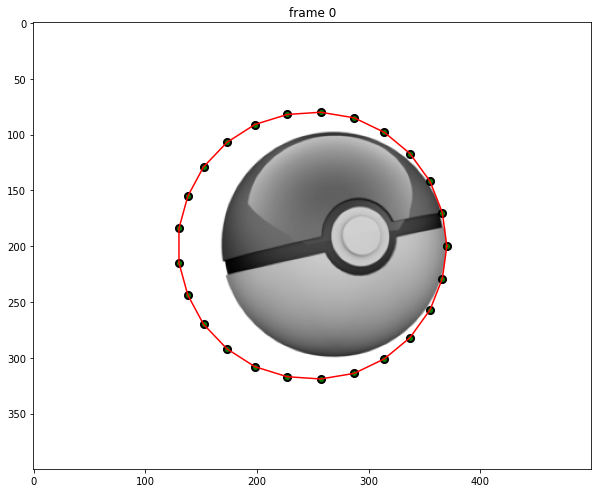

IndexError: index 300 is out of bounds for axis 0 with size 300

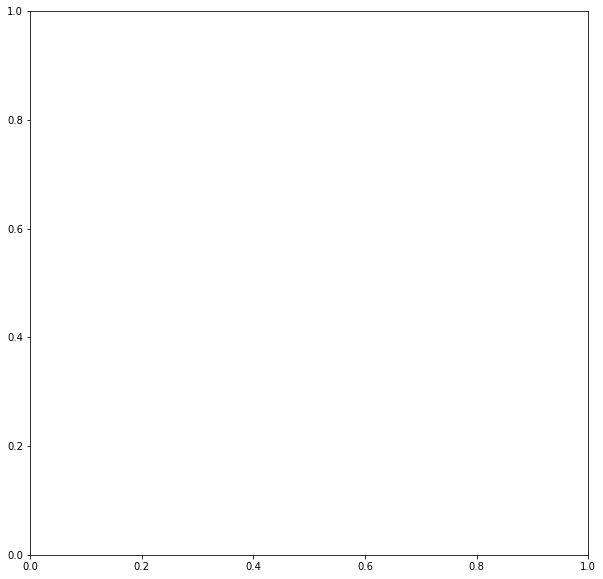

In [27]:
def plot_snake(ax, V, fill='green', line='red', alpha=1, with_txt=False):
    """ plots the snake onto a sub-plot
    :param ax: subplot (fig.add_subplot(abc))
    :param V: point locations ( [ (x0, y0), (x1, y1), ... (xn, yn)]
    :param fill: point color
    :param line: line color
    :param alpha: [0 .. 1]
    :param with_txt: if True plot numbers as well
    :return:
    """
    V_plt = np.append(V.reshape(-1), V[0,:]).reshape((-1, 2))
    ax.plot(V_plt[:,0], V_plt[:,1], color=line, alpha=alpha)
    ax.scatter(V[:,0], V[:,1], color=fill,
               edgecolors='black',
               linewidth=2, s=50, alpha=alpha)
    if with_txt:
        for i, (x, y) in enumerate(V):
            ax.text(x, y, str(i))


def load_data(fpath, radius):
    """
    :param fpath:
    :param radius:
    :return:
    """
    Im = cv2.imread(fpath, 0)
    h, w = Im.shape
    n = 25  # number of points
    u = lambda i: radius * np.cos(i) + w / 2
    v = lambda i: radius * np.sin(i) + h / 2
    V = np.array(
        [(u(i), v(i)) for i in np.linspace(0, 2 * np.pi, n + 1)][0:-1],
        'int32')

    return Im, V

# is the internal energy
def compute_graph_dist_mean(V):
    distances = []
    for (y1,x1), (y2,x2) in zip(V, V[1:-1]):
        distances.append(np.sqrt((x1-x2)**2 + (y1-y2)**2))
    return distances, np.mean(distances)

# TODO: finish computation of P
def euclid_arr(P, U, k):
    euclid_arr = np.zeros_like(P)
    # loop over each vertex pair
    for v_idx in range(1, U.shape[0]):
        # loop over neighborhood or former vertex
        for neigh in range(k*k):
            # get idx of former vertex array
            idx_y = neigh % k
            idx_x = neigh / k
            # from former vertex arr save euclid distance 
            for i in range(k):
                for j in range(k):
                    # set 
                    P[v_idx - 1, neigh] = np.sqrt(
                        (U[v_idx-1, 1, i, j] - U[v_idx-1, 1])**2 # y dim
                        + ((U[v_idx-1, 2, i, j] - U[v_idx-1, 2])**2).T # x dim
                        )
    return P

        

# TODO: compute elastic energy from euclid arr (subtract with avg d and multiply with alpha val)
def elastic_energy(P, U, k, old_avg, alpha=1):
    new_P = np.array(euclid_arr(P, U, k))
    elastic = alpha * (new_P - old_avg)**2
    return elastic

def magnitude_img(image):
    # already grayscale given
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = grad_x**2 + grad_y**2
    return magnitude

def snake_step(image, V, U, P, k):

    width = np.floor(k/2)
    # take minus of magnitude image for external energy
    external_energy = -magnitude_img(image)
    # iterate over every vertex in V
    for v_idx, (y, x) in enumerate(V):
        # get idx of 8 neighborhood
        for i in range(k):
            for j in range(k):
                U[v_idx, 0, i, j] = external_energy[y - 1 + i, x - 1 + j]
                U[v_idx, 1, i, j] = y - 1 + i
                U[v_idx, 2, i, j] = x - 1 + j

    old_dist, old_avg = compute_graph_dist_mean(V)
    new_P = elastic_energy(P, U, k, old_avg)



def run(fpath, radius):
    """ run experiment
    :param fpath:
    :param radius:
    :return:
    """
    Im, V = load_data(fpath, radius)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    n_steps = 1

    # set filter neighborhoodsize:
    k = 3

    # unary array: for each vertex save neighborhood and coords(y dim x dim)
    unary = np.zeros((V.shape[0], 3, k, k))
    # pairwise for each vertex save neighborhood and it's distances to the next vertex neighborhood
    pairwise = np.zeros((V.shape[0] - 1, k*k, k, k))


    for t in range(n_steps):
        snake_step(Im, V, unary, pairwise, k)

        ax.clear()
        ax.imshow(Im, cmap='gray')
        ax.set_title('frame ' + str(t))
        plot_snake(ax, V)
        plt.pause(0.01)

    plt.pause(2)


if __name__ == '__main__':
    run('images/ball.png', radius=120)
    run('images/coffee.png', radius=100)


**2.**

Read the image ball.png, resize it to half the size, and segment the object in the
image using level-sets with an geodesic active contour. 

Initialize the contour by a circle around the object and compute a signed distance transform to initialize the
level-set function. 

Optimize the geodesic contour by gradient descent.

Visualize for the image how the level-set function changes and how the contour converges to the
boundary of the object.

The proposed metric in geodesic active contours is:

$$
w(| \nabla I |) = \frac{I}{| \nabla I | + 1}
$$

(10 Points)

In [ ]:
rc('text', usetex=True)  # if you do not have latex installed simply uncomment this line + line 75


def load_data():
    """ loads the data for this task
    :return:
    """
    fpath = 'images/ball.png'
    radius = 70
    Im = cv2.imread(fpath, 0).astype('float32')/255  # 0 .. 1

    # we resize the image to speed-up the level set method
    Im = cv2.resize(Im, dsize=(0, 0), fx=0.5, fy=0.5)

    height, width = Im.shape

    centre = (width // 2, height // 2)
    Y, X = np.ogrid[:height, :width]
    phi = radius - np.sqrt((X - centre[0]) ** 2 + (Y - centre[1]) ** 2)

    return Im, phi


def get_contour(phi):
    """ get all points on the contour
    :param phi:
    :return: [(x, y), (x, y), ....]  points on contour
    """
    eps = 1
    A = (phi > -eps) * 1
    B = (phi < eps) * 1
    D = (A - B).astype(np.int32)
    D = (D == 0) * 1
    Y, X = np.nonzero(D)
    return np.array([X, Y]).transpose()

# ===========================================
# RUNNING
# ===========================================

# FUNCTIONS
# ------------------------
# your implementation here

# ------------------------


if __name__ == '__main__':

    n_steps = 20000
    plot_every_n_step = 100

    Im, phi = load_data()

    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    # ------------------------
    # your implementation here

    # ------------------------

    for t in range(n_steps):

        # ------------------------
        # your implementation here

        # ------------------------

        if t % plot_every_n_step == 0:
            ax1.clear()
            ax1.imshow(Im, cmap='gray')
            ax1.set_title('frame ' + str(t))

            contour = get_contour(phi)
            if len(contour) > 0:
                ax1.scatter(contour[:, 0], contour[:, 1], color='red', s=1)

            ax2.clear()
            ax2.imshow(phi)
            ax2.set_title(r'$\phi$', fontsize=22)
            plt.pause(0.01)

    plt.show()
